## Faezeh Yazdi Capstone Project - Food Recomendation System

## Notebook : FunkSVD recommendation system
This notebook aims to build a recommendation system by using FunkSVD.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(0)

Importing review dataset.

In [4]:
df = pd.read_parquet("Transformed Data/ cleanedReviewdf.parquet")

In [5]:
df.head()

,ReviewId,RecipeId,Review_AuthorId,Review_AuthorName,Review_Rating,Review,Review_DateSubmitted
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25 21:44:00+00:00
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17 16:49:59+00:00
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25 09:00:00+00:00
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13 21:15:00+00:00
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28 12:51:00+00:00


In [6]:
df.shape

(1401982, 7)

Our dataset is very huge and unfortunately we do not have enough computational power to run our model on all of them. So we need an approach to choose rows. one way is to filter the recipes which has low number of reviews.

In [7]:
#filter recipes with less than 10 reviews
counts = df['RecipeId'].value_counts()

print('Number of recipes:',counts[counts>10].shape[0] )
print('Total number of reviews: ',df[df['RecipeId'].isin(counts[counts>100].index)].shape[0])


Number of recipes: 23429
Total number of reviews:  225178


In [8]:
#recipes with more than 10 reviews 
df = df[df['RecipeId'].isin(counts[counts>10].index)]

In order to avoid bias in our model we need to check for balance classes. Firstly, a FunkSVD model has been run and the too good FCP and other evaluation metrics remind us the importance of balancing data. So, in this our final model lets balance classes. As we have huge dataset we will do it by undersampling.

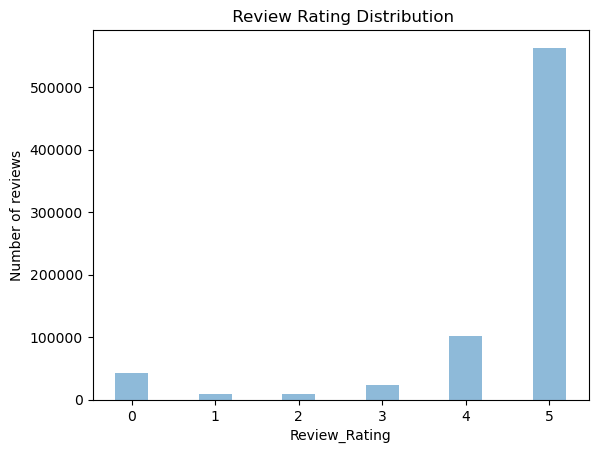

In [9]:
#distribution of classes
plt.figure()
plt.bar(df["Review_Rating"].value_counts().index, df["Review_Rating"].value_counts().values, alpha=0.5, width= 0.4)
plt.ylabel('Number of reviews')
plt.xlabel('Review_Rating')
plt.title(' Review Rating Distribution')
plt.show()

In [10]:
#number of rows in each class
df["Review_Rating"].value_counts()

5    563195
4    102347
0     43267
3     23555
2      9221
1      8598
Name: Review_Rating, dtype: int64

Choose the smallest class and under sample the others to that size.

In [11]:
#under sampling
df_0_sample = df[df['Review_Rating']==0].sample(n=8598, replace=False, random_state=1)
df_1_sample = df[df['Review_Rating']==1].sample(n=8598, replace=False, random_state=1)
df_2_sample = df[df['Review_Rating']==2].sample(n=8598, replace=False, random_state=1)
df_3_sample = df[df['Review_Rating']==3].sample(n=8598, replace=False, random_state=1)
df_4_sample = df[df['Review_Rating']==4].sample(n=8598, replace=False, random_state=1)
df_5_sample = df[df['Review_Rating']==5].sample(n=8598, replace=False, random_state=1)

#sanity check
print(df_0_sample.shape,df_1_sample.shape,df_2_sample.shape,df_3_sample.shape,df_4_sample.shape,df_5_sample.shape)

(8598, 7) (8598, 7) (8598, 7) (8598, 7) (8598, 7) (8598, 7)


In [12]:
#define the balance df
df_balance = pd.concat([df_0_sample,df_1_sample,df_2_sample,df_3_sample,df_4_sample,df_5_sample])

df_balance.shape

(51588, 7)

In [13]:
#sanity check
counts = df_balance['RecipeId'].value_counts()
print('Number of recipes:',counts.shape[0] )

Number of recipes: 16314


Modify dataset in our desired format of columns to be ready for modeling.

In [14]:
df = df_balance[['RecipeId','Review_AuthorId','Review_Rating']]
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df.head()

/var/folders/bg/nwrfqr3x53x6dwwjtgkf3bl80000gn/T/ipykernel_4918/846660306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['index'],inplace=True)


,RecipeId,Review_AuthorId,Review_Rating
0,9954,528656,0
1,430350,2000017994,0
2,121823,2907464,0
3,88578,357567,0
4,132916,2001361374,0


## Building User Item Utility matrix

Lets first build R dataframe. R data frame includes all the users in rows and all the recipes in columns and each value would be the rating the user have given to that recipe.

In [15]:
users = df['Review_AuthorId'].unique()
recipes = df['RecipeId'].unique()

num_users = len(users)
num_recipe = len(recipes)
           
# np.nan means they user has not reviewed the recipe
R = np.full((num_users, num_recipe), np.nan)

#maping ids to numbers from zero to length
recipe_index = {id:i for i, id in enumerate(recipes)}
author_index = {id:i for i, id in enumerate(users)}

#Build the user-item matrix
for row in df.itertuples(): 
    user = row[2]
    recipe = row[1]
    rating = row[3]
    i = author_index[user]
    j = recipe_index[recipe]
    R[i, j] = rating
    
R_df = pd.DataFrame(data=R, index=users, columns=recipes)

In [16]:
#sanity check
R_df

,9954,430350,121823,88578,132916,12677,38748,607,37023,80247,...,412634,282066,244839,24133,121959,66058,422998,67579,186365,263152
528656,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000017994,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2907464,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357567,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001361374,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
631878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2870378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Funk Singular Value Decomposition (FunkSVD)
Now by making use of FunkSVD we can defactorize the R matrix.

In [17]:
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD

In [18]:
# Predicting user rating for a recipe using FunkSVD Function


def Rating_FunkSVD(df,user_id,recipe_id):#input data frame should include recipeId, userId, rating columns respectively
    
    #Surprise format data
    my_dataset = Dataset.load_from_df(df, Reader(rating_scale=(1, 5)))
    my_train_dataset = my_dataset.build_full_trainset()
    
    #initial algorithm
    my_algorithm = FunkSVD(n_factors=10, 
                       n_epochs=100, 
                       lr_all=0.1,    # Learning rate for each epoch
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=0)
    #fit algorithm
    my_algorithm.fit(my_train_dataset)
    
    #user matrix
    U = my_algorithm.pu
    
    #recipe matrix
    Re = my_algorithm.qi.T
    
    # find the inner representation of the user
    inner_user_id = my_train_dataset.to_inner_uid(user_id)  
    user_profile = U[inner_user_id]
    
    # find the inner representation of the item
    inner_recipe_id = my_train_dataset.to_inner_iid(recipe_id) 
    recipe_profile = Re[:, inner_recipe_id]
    
    #predict rating
    expected_rating = np.dot(user_profile, recipe_profile)
    
    return expected_rating;
    
    
    

### Test the Model
Lets test it with a sample user and a sample recipe.

In [19]:
#First sort columns of input dataframe --> beacuse it has been hard coded
sorted_df = df_balance[['Review_AuthorId','RecipeId','Review_Rating']]

In [20]:
sorted_df.sample()

,Review_AuthorId,RecipeId,Review_Rating
922993,1525745,134974,2


In [21]:
#dont forget the first input is authorid and the second is review
Rating_FunkSVD(sorted_df,20828,3846)

3.980000837861337

The actual rating for user 20828 for the recipe 3846 is 4 and the model is predicting this 3.98.:)

Now we can write a function to input a user and then it would predict the rating for all the recipes and sort base on the highest rating and recommend the top one.

Now let's see how is it working for other ones and check the metrics.

### Accuracy of FunkSVD 

In [22]:
from surprise import accuracy
from surprise.model_selection import train_test_split

my_dataset = Dataset.load_from_df(df, Reader(rating_scale=(1, 5)))
my_train_dataset = my_dataset.build_full_trainset()
    
#initial algorithm
my_algorithm = FunkSVD(n_factors=10, 
                       n_epochs=100, 
                       lr_all=0.1,    # Learning rate for each epoch
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=0)
#fit algorithm
my_algorithm.fit(my_train_dataset)

# The surprise package doesn't allow you to test on the trainset we built
my_train_dataset, my_test_dataset = train_test_split(my_dataset, test_size=0.5)

predictions = my_algorithm.test(my_test_dataset)

In [23]:
# RMSE
RMSE = accuracy.rmse(predictions, verbose=False)
print(RMSE)

0.4112345071967373


In [24]:
# MSE
MSE = accuracy.mse(predictions, verbose=False)
print(MSE)

0.1691138199093434


In [25]:
# MAE
MAE = accuracy.mae(predictions, verbose=False)
print(MAE)

0.18954446115278484


In [26]:
# FCP - Fraction of Concordant Pairs, the fraction of pairs whose relative ranking order is correct

FCP = accuracy.fcp(predictions, verbose=False)
print(FCP) 

0.9055959617027479


As we can see quantitively our FunkSVD is doing a good job in terms of predicting the rating each user can give to a recipe. For further steps we can tune our hyperprameters like n_factors, n_epochs, and lr_all.

---

## Recommending with FunkSVD - First Aproach 
Now for making recommendations we need to predict the user rating for all recipes which they had not rated yet and recommed them the best ones.

As we have 16K different recipes and calculating predicted rating for all of them is very computationaly expensive, for now we just choose a sample of them.

In [27]:
#choose a sample of recipes
unique_RecipeIds = sorted_df['RecipeId'].unique()
sample_recipes = unique_RecipeIds[-20:]

In [28]:
#sanity check
sample_recipes

array([381852,  61389,  95386, 199210,  52192, 246888, 238907,  85197,
       154537, 197977, 412634, 282066, 244839,  24133, 121959,  66058,
       422998,  67579, 186365, 263152], dtype=int32)

In [29]:
#choose a authorid
sorted_df['Review_AuthorId'].value_counts()

218535        169
55729          93
198154         90
140132         83
369715         68
             ... 
2001580795      1
1578949         1
2002279336      1
1800204000      1
2336635         1
Name: Review_AuthorId, Length: 31507, dtype: int64

In [30]:
#choosen user
Userid = 55729

#find already rated recipes to not recommend similar recipes
already_rated = sorted_df[sorted_df['Review_AuthorId']==Userid]['RecipeId']

#empty list
recipeids = []
predicted_ratings = []

for recipe in sample_recipes:
    
#    #check if already has been rated
     if recipe not in already_rated:
        
        #predict the rating
        #first input is authorid and the second is review
        predicted_ratings.append(Rating_FunkSVD(sorted_df,Userid,recipe))
        recipeids.append(recipe)
    

# create a dataframe of predicted ratings    
recom_df = pd.DataFrame({'recipeid': recipeids, 'predicted_rating': predicted_ratings})
recom_df.sort_values('predicted_rating', ascending=False).head(5)        

,recipeid,predicted_rating
12,244839,1.975645
9,197977,1.862588
3,199210,1.358781
11,282066,0.984056
16,422998,0.816726


## Recommending with FunkSVD - Second Aproach 

The other approach for recommending with FunckSVD is predicting ratings for all the recipes inside the function , sort them and return the top ones. This would be way more faster and we dont need to filter for some recipes any more.

In [95]:
# finding the best rated recipes for certain user


def recom_Rating_FunkSVD(df,user_id):
    
    #Surprise format data
    my_dataset = Dataset.load_from_df(sorted_df, Reader(rating_scale=(1, 5)))
    my_train_dataset = my_dataset.build_full_trainset()
    
    my_algorithm = FunkSVD(n_factors=10,n_epochs=100, 
    lr_all=0.1,    # Learning rate for each epoch
    biased=False,  # This forces the algorithm to store all latent information in the matrices
    verbose=0,random_state=10)
    
    my_algorithm.fit(my_train_dataset)
    
    U = my_algorithm.pu
    Re = my_algorithm.qi.T

    
    # find the inner representation of the user
    inner_user_id = my_train_dataset.to_inner_uid(user_id)  
    user_profile = U[inner_user_id]
    
    #ALL RECIPES
    recipe_profile = Re[:, :]
    
    #predict rating
    expected_rating = np.dot(user_profile, recipe_profile)
    
    #match ratings with recipeids
    predicted_df = pd.DataFrame({'recipeid':df['RecipeId'].unique(),'predicted_rating':expected_rating})
    predicted_df = predicted_df[~(predicted_df['recipeid'].isin(rated_recipes_info['RecipeId'].values))]
    
    #top rated recipes IDs
    top_recipes_id = predicted_df.sort_values('predicted_rating',ascending=False).head()['recipeid'].values
    
    #Find recipe names
    out_put = recipe_df[recipe_df['RecipeId'].isin(top_recipes_id)]['Name']
    
    return out_put

This function returns the recipeid not the names. for finding the names we need to use our main recipe dataset.

In [35]:
#import recipe dataset
recipe_df = pd.read_parquet("Raw Data/recipes.parquet")

Now, lets test it with a user.

In [96]:
#choose a userid who rated about 5 recipes

my_sample =pd.DataFrame({'auhorid':sorted_df['Review_AuthorId'].value_counts().index, 'NumberofRate': sorted_df['Review_AuthorId'].value_counts().values})

my_sample[my_sample['NumberofRate']>4].tail()


,auhorid,NumberofRate
1417,420929,5
1418,235355,5
1419,567976,5
1420,1064617,5
1421,589581,5


In [112]:
###### Make sure to run this code; it affects the filtering in the function to avoid recommending the recipes already rated
############################


#what recipes has rated --> input author ID

rated_recipe = sorted_df[sorted_df['Review_AuthorId']==1064617]
recipe_info = recipe_df[recipe_df['RecipeId'].isin(rated_recipe['RecipeId'].values)]
merged = pd.merge(rated_recipe,recipe_info, left_on='RecipeId', right_on='RecipeId')
rated_recipes_info = merged[['Name','Review_Rating','RecipeId']].sort_values('Review_Rating',ascending=False)
print(rated_recipes_info)


                                            Name  Review_Rating  RecipeId
4                         Hot Feta Artichoke Dip              4     30914
1     Orange Julius With  the Secret Ingredient!              3    108936
2                            Banana Banana Bread              3     25885
3                              Crazy Crust Pizza              3     29002
0  Baked French Toast Casserole With Maple Syrup              0     90246


In [113]:
#use sorted df and the UserID
recom_Rating_FunkSVD(sorted_df,1064617)

9037                      Crispy Parmesan Roasted Asparagus
9381                                         Ginger Chicken
24105                            Ice Cream Sandwich Dessert
68651                            Kittencal's Caramel Apples
248413    Delicious Chewy Peanut Butter Chocolate Chip O...
Name: Name, dtype: object